In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

In [37]:
import matplotlib.pyplot as plt

In [2]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

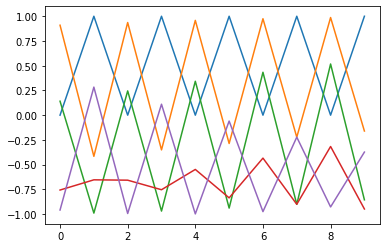

In [10]:
plt.plot(pe[0][:10])
plt.plot(pe[2][:10])
plt.plot(pe[3][:10])
plt.plot(pe[4][:10])
plt.plot(pe[5][:10])

In [24]:
pe = PositionalEmbedding(512)

In [25]:
inpt = torch.Tensor(321,96,5)

In [26]:
inpt.shape

torch.Size([321, 96, 5])

In [27]:
embedded_inpt = pe(inpt)

In [28]:
embedded_inpt.shape

torch.Size([1, 96, 512])

In [30]:
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

In [32]:
token_embedding = TokenEmbedding(5, 512)

In [33]:
token_inpt = token_embedding(inpt)

In [34]:
token_inpt.shape

torch.Size([321, 96, 512])

In [35]:
class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)
    
    def forward(self, x):
        x = x.long()
        
        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])
        
        return hour_x + weekday_x + day_x + month_x + minute_x